# HONGOS

In [12]:
%config IPCompleter.greedy=True

In [13]:
#Para omitir FutureWarning's en el resto del codigo
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [14]:
#paquete para tensores
import tensorflow as tf

In [15]:
#paquetes de siempre
import numpy as np
import pandas as pd

In [16]:
#paquetes para el analisis
import os                             
import skimage.io as im               #leer imagenes
import matplotlib.pyplot as plt
import random
import sklearn.model_selection as skl #train_test_split()
from skimage import transform         #reescalado
from skimage.color import rgb2gray    #escala de grises

## Cargar datos

In [17]:
#Directorio de trabajo
path = 'C:/Users/jvill/Documents/ESCUELA/Machine Learning/Datasets/Protocolo IA'

In [18]:
def cargar_datos(path):
    dirs = [d for d in os.listdir(path)
     if os.path.isdir(os.path.join(path,d))]

    labels = [] ; 
    images = []    

    for d in dirs:
        label_dir = os.path.join(path,d)
        file_names = [os.path.join(label_dir,f) 
                          for f in os.listdir(label_dir)]        
        for f in file_names:
            images.append(im.imread(f))    #Lee imagen 
            labels.append(d) #¿A qué carpeta pertenece la imagen?
            
    return images, labels

In [19]:
imagenes, etiquetas = cargar_datos(path)

In [20]:
#Se comprueba la carga
len(imagenes)  

412

In [21]:
imagenes[0].nbytes

4330560

Dividir las imagenes en 2 conjuntos Training - Testing 

(Proporciones recomendadas: 70-30,  75-25,  80-20)

Como se cuenta con pocas imágenes, primero se hará el análisis exploratorio para determinar si conviene o no dividir el dataset.

## Analisis exploratorio

In [22]:
#Numero de imagenes en el conjunto
num_img = len(imagenes)
num_eti = len(etiquetas)
if num_img==num_eti: print(num_img)

412


In [23]:
#Dimensiones de la primera imagen
first_shape = imagenes[0].shape
print(first_shape) 

(1040, 1388, 3)


In [24]:
#Corroborar misma dimension en todas las imagenes
for i in range(num_img):
    if imagenes[i].shape != first_shape:
        print('imagen', i,'diferente')  #Si hay alguna imagen de dimensiones diferentes, lo indicará

Todas las imagenes del dataset tienen el mismo tamaño, en este caso, *first_shape*

### Histograma de frecuencias de las especies

In [25]:
#Especies de hongos en el dataset
especies = set(etiquetas)
especies

{'Chrysosporium',
 'Microsporum canis',
 'Trichophyton mentagrophytes',
 'Trichophyton rubrum',
 'Trichophyton tonsurans'}

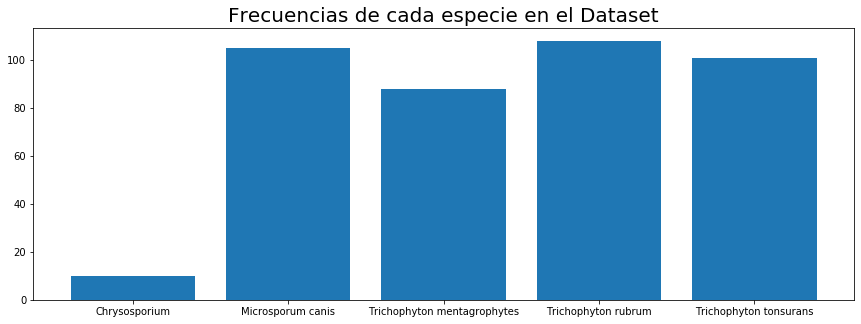

In [26]:
#Histograma de especies
frecuencias = np.unique(np.array(etiquetas),return_counts=True)
names = frecuencias[0]
values = frecuencias[1]
plt.figure(figsize=(50, 5))
plt.subplot(131)
plt.bar(names, values)
plt.title('Frecuencias de cada especie en el Dataset', size=20)
plt.show()

In [27]:
#Numero de fotos de cada especie
values

array([ 10, 105,  88, 108, 101], dtype=int64)

La especie Chrysosporium tiene muy pocos elementos, por lo tanto, no se dividirá el dataset en imagenes de entrenamiento e imagenes de evaluacion, ya que se podría perder demasiada información, quedándose con 7 u 8 imagenes para entrenar esa especie. En cambio, la validación al final se hará utilizando una muestra aleatoria del dataset.

Se considerará todo el conjunto como conjunto de entrenamiento.

In [28]:
#etiquetas_train,etiquetas_test,imagenes_train,imagenes_test = skl.train_test_split(etiquetas,imagenes, test_size = 0.2)

### Primera foto de cada especie

In [29]:
#Recordar el conjunto "especies"
especies

{'Chrysosporium',
 'Microsporum canis',
 'Trichophyton mentagrophytes',
 'Trichophyton rubrum',
 'Trichophyton tonsurans'}

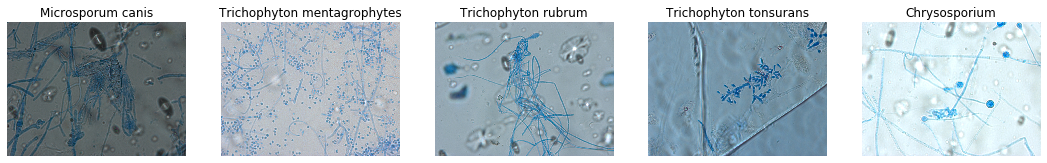

In [30]:
#Visualizar fotos de especies
plt.figure(figsize=(30,30))
i=1
for especie in especies:
    img_temp = imagenes[etiquetas.index(especie)] #index arroja sólo el primer indice que contiene 'especie'
    plt.subplot(8,8,i)
    plt.axis("off")
    plt.title(especie)#+' ('+str(etiquetas.count(especie))+')')    
    i+=1
    plt.imshow(img_temp)
    
plt.show()
    

### 3 Fotos aleatorias de cada especie

In [31]:
#Funcion para obtener todos los indices de las fotos de cada especie
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]

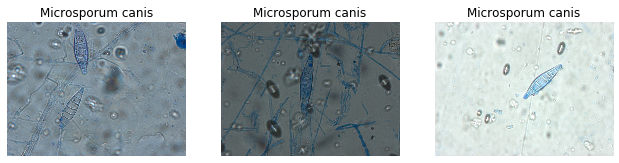

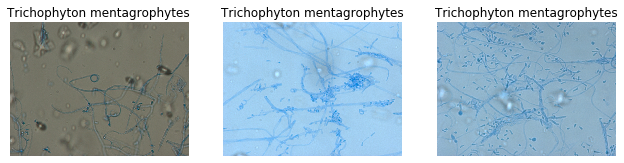

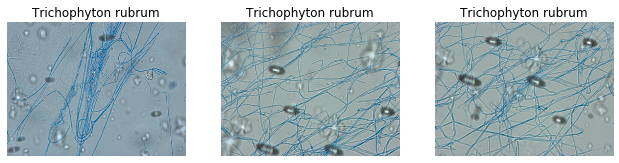

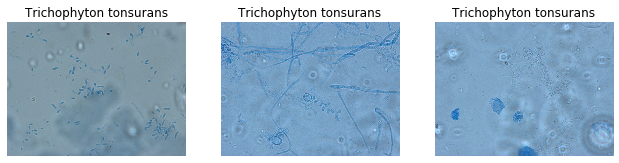

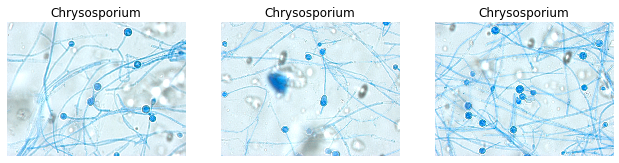

In [32]:
for especie in especies:
    indices = random.sample(get_indexes(especie,etiquetas),3) #muestra aleatoria de 3 indices
    plt.figure(figsize=(30,30))
    
    for i in range(3):
        plt.subplot(8,8,i+1)
        plt.axis("off")
        plt.title(especie) 
        plt.imshow(imagenes[indices[i]])
    plt.show()

## Tratamiento de imágenes

Resumen de la exploración anterior:
* Las imágenes son todas mismo tamaño *(1040, 1388, 3)*
* Hay 5 clases de imágenes *(Chrysosporium,Microsporum canis,Trichophyton mentagrophytes,Trichophyton rubrum,Trichophyton tonsurans)*
* La distribucion de especies no es uniforme y la especie *Chrysosporium* cuenta sólo 10 fotos

### Reescalado

En el caso de esta base de datos, se corroboró, en el análisis exploratorio, que todas las imágenes tienen las mismas dimensiones. No se presenta la necesidad de reescalar a todas las imágenes al mismo tamaño. Pero son demasiado grandes y se debe reducir su tamaño para el modelo de reconocimiento.

Después de muchas pruebas de tamaño para reescalar, se llegó a que un tamaño óptimo era 104x139 pxls

In [33]:
imagenes[0].shape #Dimension de las imagenes

(1040, 1388, 3)

In [34]:
imagenes[0].size

4330560

In [35]:
imagenes[0].nbytes

4330560

In [36]:
imagenes = [transform.resize(imagen,(104,139)) for imagen in imagenes] #transformacion

In [37]:
imagenes[0].shape #Nueva dimension de las imagenes

(104, 139, 3)

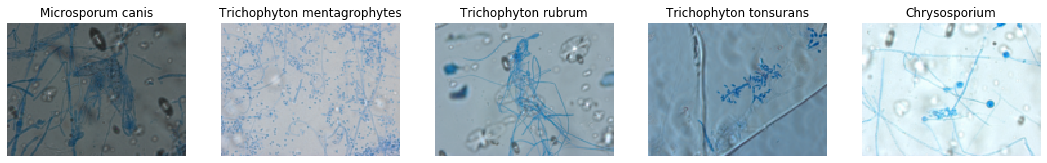

In [38]:
#Visualizar fotos de especies
plt.figure(figsize=(30,30))
i=1
for especie in especies:
    img_temp = imagenes[etiquetas.index(especie)] #index arroja sólo el primer indice que contiene 'especie'
    plt.subplot(8,8,i)
    plt.axis("off")
    plt.title(especie)#+' ('+str(etiquetas.count(especie))+')')    
    i+=1
    plt.imshow(img_temp)
    
plt.show()
    

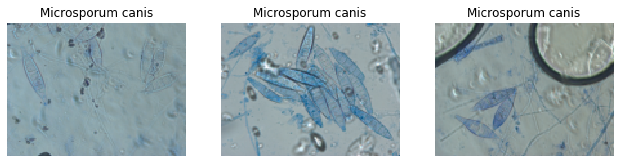

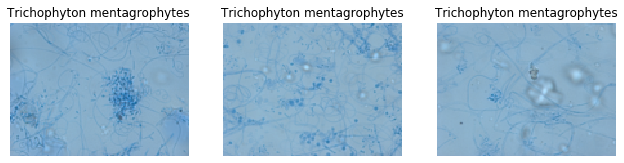

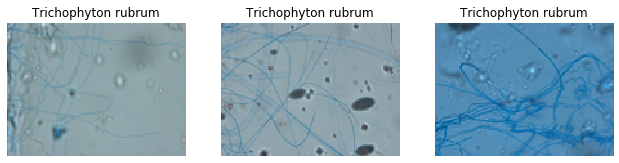

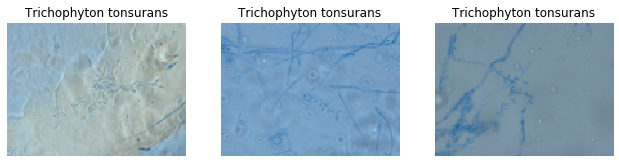

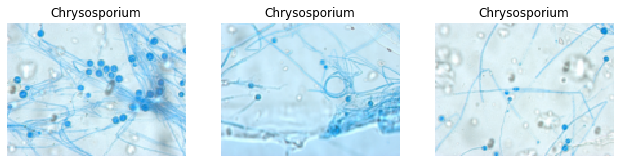

In [39]:
for especie in especies:
    indices = random.sample(get_indexes(especie,etiquetas),3) #muestra aleatoria de 3 indices
    plt.figure(figsize=(30,30))
    
    for i in range(3):
        plt.subplot(8,8,i+1)
        plt.axis("off")
        plt.title(especie) 
        plt.imshow(imagenes[indices[i]])
    plt.show()

### Colores a grises

In [40]:
imagenes[0]  #imagen en rgb

array([[[0.87058824, 0.92352941, 0.96470588],
        [0.87348709, 0.93034984, 0.96956552],
        [0.88039216, 0.94509804, 0.98431373],
        ...,
        [0.88417266, 0.94012555, 0.96848639],
        [0.9029835 , 0.94910425, 0.96180702],
        [0.88033573, 0.91366906, 0.93918747]],

       [[0.86666667, 0.92156863, 0.96271689],
        [0.87058824, 0.92941176, 0.97254902],
        [0.85686275, 0.93333333, 0.97345888],
        ...,
        [0.90090986, 0.96169417, 0.98823529],
        [0.88030752, 0.93623219, 0.96666667],
        [0.8627451 , 0.9254902 , 0.95490196]],

       [[0.86666667, 0.92253491, 0.96470588],
        [0.8745098 , 0.93333333, 0.97254902],
        [0.8627451 , 0.93816476, 0.97647059],
        ...,
        [0.89803922, 0.9627451 , 0.99215686],
        [0.89207222, 0.95089575, 0.98039216],
        [0.87252081, 0.93233883, 0.9617506 ]],

       ...,

       [[0.87843137, 0.93037805, 0.97058824],
        [0.88133023, 0.94509804, 0.98039216],
        [0.89019608, 0

In [41]:
imagenes = np.array(imagenes)  #Convierto la lista a arreglo
imagenes = rgb2gray(imagenes)  #Convierto las imagenes a escala de grises

In [42]:
imagenes[0] #imagen en grises

array([[0.91524824, 0.92109396, 0.93417549, ..., 0.93028038, 0.94021946,
        0.90842561],
       [0.91286875, 0.92002196, 0.91997639, ..., 0.95069112, 0.92654252,
        0.91427745],
       [0.91370344, 0.92366078, 0.92489993, ..., 0.95111569, 0.94052244,
        0.92174809],
       ...,
       [0.92223854, 0.93409209, 0.93981614, ..., 0.93270542, 0.93086469,
        0.92715678],
       [0.91306232, 0.9341575 , 0.93080451, ..., 0.92634653, 0.92090803,
        0.92198058],
       [0.91077216, 0.9079104 , 0.91761047, ..., 0.91860039, 0.91776706,
        0.92286896]])

In [43]:
imagenes[0].shape  

(104, 139)

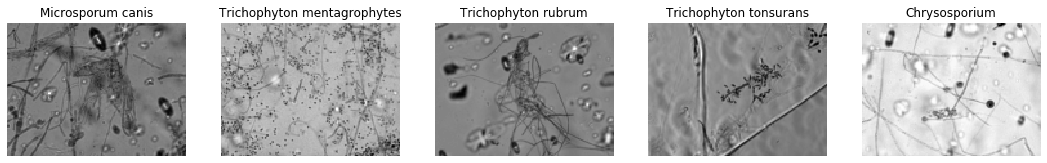

In [44]:
#Visualizar fotos de especies
plt.figure(figsize=(30,30))
i=1
for especie in especies:
    img_temp = imagenes[etiquetas.index(especie)] #index arroja sólo el primer indice que contiene 'especie'
    plt.subplot(8,8,i)
    plt.axis("off")
    plt.title(especie)#+' ('+str(etiquetas.count(especie))+')')    
    i+=1
    plt.imshow(img_temp, cmap = 'gray')
    
plt.show()
    

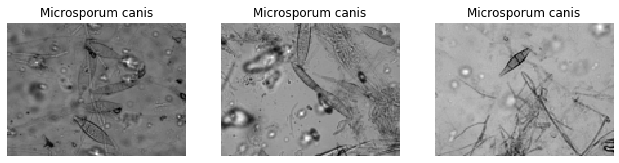

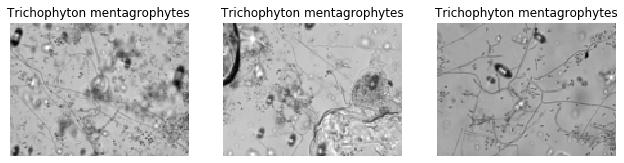

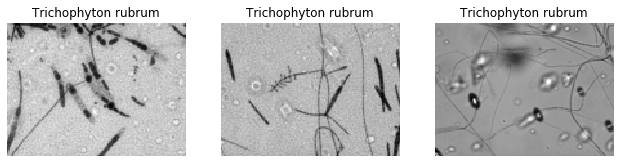

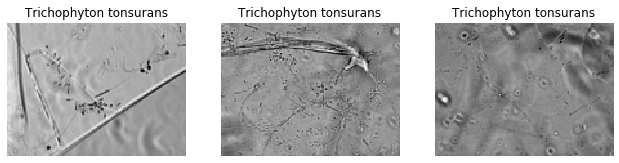

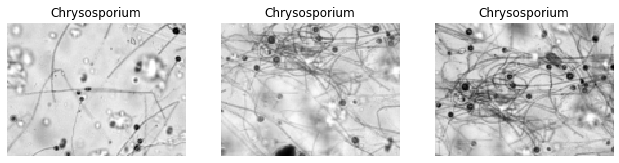

In [45]:
for especie in especies:
    indices = random.sample(get_indexes(especie,etiquetas),3) #muestra aleatoria de 3 indices
    plt.figure(figsize=(30,30))
    
    for i in range(3):
        plt.subplot(8,8,i+1)
        plt.axis("off")
        plt.title(especie) 
        plt.imshow(imagenes[indices[i]],cmap='gray')
    plt.show()

## Modelo de Red Neuronal

## Grafo 

In [102]:
#Funcion para asignar a cada especie un numero
def asignar_numero(x):
    return {
        'Chrysosporium': 0,
        'Microsporum canis': 1,
        'Trichophyton mentagrophytes': 2,
        'Trichophyton rubrum': 3,
        'Trichophyton tonsurans': 4,
    }[x]

In [103]:
#Lista de etiquetas para usar en el modelo
etiquetas2 = []
for eti in etiquetas:
    etiquetas2.append(asignar_numero(eti))

In [ ]:
#Puntos de entrada de la red:
x = tf.placeholder(dtype = tf.float64, shape = [None,104,139]) 
y = tf.placeholder(dtype = tf.int32, shape = [None])         

#Convierte las matrices de 104x139 a listas de 14456
aplanadas = tf.contrib.layers.flatten(x)  

# Se utilizará la red neuronal para hacer una clasificacion logistica con 5 salidas.
# la clasificacion se utiliza para predecir variables discretas.

#Capa de conexion: tf.contrib.layers.fully_connected(inputs,num_outputs,activation_fn)
logits = tf.contrib.layers.fully_connected(aplanadas,5,tf.nn.relu)

#Funcion de perdida:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits))

#Optimizador:
train_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

#Prediccion final:
final_pred = tf.argmax(logits,1)

#Precisión del modelo:
accuracy = tf.reduce_mean(tf.cast(final_pred,tf.float32))

### Ejecucion del modelo

In [106]:
tf.set_random_seed(1234)

sess = tf.Session()

sess.run(tf.global_variables_initializer())

#Iteraciones para aprendizaje
for i in range(601):
    _, accuracy_val, loss_val= sess.run([train_opt,accuracy,loss], feed_dict = {x:imagenes,y:etiquetas2})
    
    if i%50==0:
        print("Epoch",i)
        print("Eficacia =",accuracy_val)
        print("Perdida =",loss_val)

Epoch 0
Eficacia = 1.9975728
Perdida = 1.6333272599543587
Epoch 50
Eficacia = 0.0
Perdida = 1.6094379124340943
Epoch 100
Eficacia = 0.0
Perdida = 1.6094379124340943
Epoch 150
Eficacia = 0.0
Perdida = 1.6094379124340943
Epoch 200
Eficacia = 0.0
Perdida = 1.6094379124340943
Epoch 250
Eficacia = 0.0
Perdida = 1.6094379124340943
Epoch 300
Eficacia = 0.0
Perdida = 1.6094379124340943
Epoch 350
Eficacia = 0.0
Perdida = 1.6094379124340943
Epoch 400
Eficacia = 0.0
Perdida = 1.6094379124340943
Epoch 450
Eficacia = 0.0
Perdida = 1.6094379124340943
Epoch 500
Eficacia = 0.0
Perdida = 1.6094379124340943
Epoch 550
Eficacia = 0.0
Perdida = 1.6094379124340943
Epoch 600
Eficacia = 0.0
Perdida = 1.6094379124340943
